![header](../figures/logos_partenaires._cmems_se.jpg)


<div class="alert alert-block alert-success">
<h1><center>Compare SSH, gradients and Laplacian pdf in Gulf Stream</center></h1></div>

***
**Authors:**  Datlas, IGE, IMEDEA & CLS <br>
**Copyright:** 2022 Datlas, IGE, IMEDEA & CLS <br>
**License:** MIT

In [5]:
import os
import glob
import sys
sys.path.append('..')
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import scipy.signal as sig
import warnings
warnings.filterwarnings('ignore')


from src import mod_plot
from src import mod_switchvar
from src import mod_spectral
from src.dict_regions_info import *

In [2]:

region_info = RegionInfo('GS_info').region_info   # Region dictionary info from dict_regions_info.py
 

len_seg = 500 # in num_lines point (i.e. every 2km)

<div class="alert alert-info" role="alert">

<h2>1. Read from regional files </h2>

</div>
 

In [6]:
path_data = '../swot_versions/SWOT_v1.0/SWOT_'+region_info['name']+'_v1.0.nc' 

label_noisy_v1 = 'Noisy_v1'   # Name for plots title and saving figures
label_denoised_v1 = 'Denoised_v1'   # Name for plots title and saving figures


name_noisy_v1 = 'ssha' # Name of the denoised SWOT variable in the xarray file 
name_denoised_v1 = 'ssha_noiseless' # Name of the denoised SWOT variable in the xarray file

orbit = '1d'

ds_passes_v1 = xr.open_mfdataset(path_data,combine='nested',concat_dim='num_lines') 

In [7]:
path_data = '../swot_versions/SWOT_v2.0/SWOT_'+region_info['name']+'_v2.0.nc' 

label_noisy_v2 = 'Noisy_v2'   # Name for plots title and saving figures
label_denoised_v2 = 'Denoised_v2'   # Name for plots title and saving figures


name_noisy_v2 = 'ssha_unfiltered' # Name of the denoised SWOT variable in the xarray file 
name_denoised_v2 = 'ssha_filtered' # Name of the denoised SWOT variable in the xarray file

orbit = '1d'

ds_passes_v2 = xr.open_mfdataset(path_data,combine='nested',concat_dim='num_lines') 

## Compute psd for SSH

In [ ]:
%%time  
  
# V1

ssh_noisy_v1_segs = mod_spectral.retrieve_segments(ds_passes_v1, name_noisy_v1, len_seg) 
ssh_denoised_v1_segs = mod_spectral.retrieve_segments(ds_passes_v1, name_denoised_v1, len_seg)
 
wavenum, psd_noisy_v1 = sig.welch(np.ravel(ssh_noisy_v1_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_v1 = sig.welch(np.ravel(ssh_denoised_v1_segs),0.5,nperseg=len_seg,noverlap=0)  
wavenum, psd_noisy_v1, psd_denoised_v1 = wavenum[:-1], psd_noisy_v1[:-1], psd_denoised_v1[:-1] 

# V2

ssh_noisy_v2_segs = mod_spectral.retrieve_segments(ds_passes_v2, name_noisy_v2, len_seg) 
ssh_denoised_v2_segs = mod_spectral.retrieve_segments(ds_passes_v2, name_denoised_v2, len_seg)

wavenum, psd_noisy_v2 = sig.welch(np.ravel(ssh_noisy_v2_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_v2 = sig.welch(np.ravel(ssh_denoised_v2_segs),0.5,nperseg=len_seg,noverlap=0)  
wavenum, psd_noisy_v2, psd_denoised_v2 = wavenum[:-1], psd_noisy_v2[:-1], psd_denoised_v2[:-1] 


Number of segs 459 of size 500
Number of segs 459 of size 500
Number of segs 461 of size 500
Number of segs 461 of size 500
CPU times: user 33.1 s, sys: 729 ms, total: 33.8 s
Wall time: 44.4 s


## Plot psd for SSH

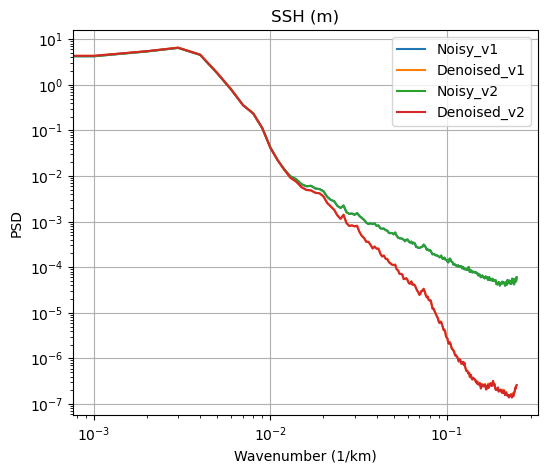

In [12]:
plt.figure(figsize=(6,5))
plt.title('SSH (m)')
plt.loglog(wavenum,psd_noisy_v1,label=label_noisy_v1)
plt.loglog(wavenum,psd_denoised_v1,label=label_denoised_v1) 
plt.loglog(wavenum,psd_noisy_v2,label=label_noisy_v2)
plt.loglog(wavenum,psd_denoised_v2,label=label_denoised_v2) 
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.grid()
plt.savefig('../figures/psd_compare_v1v2_'+region_info['name']+'_'+orbit+'_ssh.png')

plt.show()



## Compute SSH gradients and Laplacian

In [13]:
# V1

grad_noisy_v1, lapl_noisy_v1 = mod_switchvar.deriv1and2(ds_passes_v1[name_noisy_v1])
grad_denoised_v1, lapl_denoised_v1 = mod_switchvar.deriv1and2(ds_passes_v1[name_denoised_v1]) 

ds_passes_v1 = ds_passes_v1.assign(grad_noisy_v1=lambda ds_passes_v1: ds_passes_v1[name_noisy_v1] * 0 + grad_noisy_v1)
ds_passes_v1 = ds_passes_v1.assign(grad_denoised_v1=lambda ds_passes_v1: ds_passes_v1[name_denoised_v1] * 0 + grad_denoised_v1) 

ds_passes_v1 = ds_passes_v1.assign(lapl_noisy_v1=lambda ds_passes_v1: ds_passes_v1[name_noisy_v1] * 0 + lapl_noisy_v1)
ds_passes_v1 = ds_passes_v1.assign(lapl_denoised_v1=lambda ds_passes_v1: ds_passes_v1[name_denoised_v1] * 0 + lapl_denoised_v1) 

# V2

grad_noisy_v2, lapl_noisy_v2 = mod_switchvar.deriv1and2(ds_passes_v2[name_noisy_v2])
grad_denoised_v2, lapl_denoised_v2 = mod_switchvar.deriv1and2(ds_passes_v2[name_denoised_v2]) 

ds_passes_v2 = ds_passes_v2.assign(grad_noisy_v2=lambda ds_passes_v2: ds_passes_v2[name_noisy_v2] * 0 + grad_noisy_v2)
ds_passes_v2 = ds_passes_v2.assign(grad_denoised_v2=lambda ds_passes_v2: ds_passes_v2[name_denoised_v2] * 0 + grad_denoised_v2) 

ds_passes_v2 = ds_passes_v2.assign(lapl_noisy_v2=lambda ds_passes_v2: ds_passes_v2[name_noisy_v2] * 0 + lapl_noisy_v2)
ds_passes_v2 = ds_passes_v2.assign(lapl_denoised_v2=lambda ds_passes_v2: ds_passes_v2[name_denoised_v2] * 0 + lapl_denoised_v2) 


## Compute psd for gradients

In [20]:
%%time  

# V1 

name_var = 'grad_noisy_v1'
ssh_noisy_v1_segs = mod_spectral.retrieve_segments(ds_passes_v1, name_var, len_seg)

name_var = 'grad_denoised_v1'
ssh_denoised_v1_segs = mod_spectral.retrieve_segments(ds_passes_v1, name_var, len_seg)  

wavenum, psd_noisy_v1 = sig.welch(np.ravel(ssh_noisy_v1_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_v1 = sig.welch(np.ravel(ssh_denoised_v1_segs),0.5,nperseg=len_seg,noverlap=0) 

wavenum, psd_noisy_v1, psd_denoised_v1 = wavenum[:-1], psd_noisy_v1[:-1], psd_denoised_v1[:-1] 

# V2

name_var = 'grad_noisy_v2'
ssh_noisy_v2_segs = mod_spectral.retrieve_segments(ds_passes_v2, name_var, len_seg)

name_var = 'grad_denoised_v2'
ssh_denoised_v2_segs = mod_spectral.retrieve_segments(ds_passes_v2, name_var, len_seg)  

wavenum, psd_noisy_v2 = sig.welch(np.ravel(ssh_noisy_v2_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_v2 = sig.welch(np.ravel(ssh_denoised_v2_segs),0.5,nperseg=len_seg,noverlap=0) 

wavenum, psd_noisy_v2, psd_denoised_v2 = wavenum[:-1], psd_noisy_v2[:-1], psd_denoised_v2[:-1] 


Number of segs 459 of size 500
Number of segs 459 of size 500
Number of segs 461 of size 500
Number of segs 461 of size 500
CPU times: user 32.9 s, sys: 619 ms, total: 33.5 s
Wall time: 41.6 s


## Plot psd for gradients

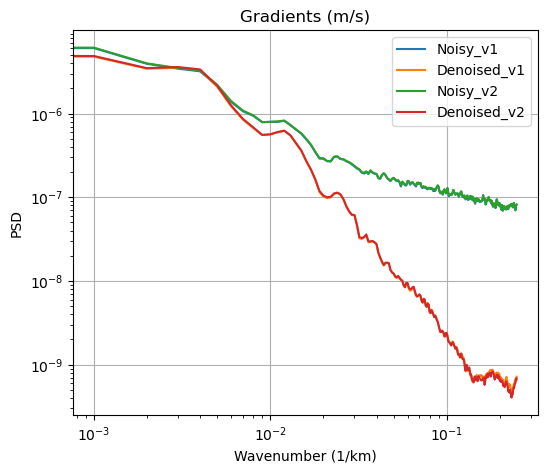

In [21]:
plt.figure(figsize=(6,5))
plt.title('Gradients (m/s)')
plt.loglog(wavenum,psd_noisy_v1,label=label_noisy_v1)
plt.loglog(wavenum,psd_denoised_v1,label=label_denoised_v1) 
plt.loglog(wavenum,psd_noisy_v2,label=label_noisy_v2)
plt.loglog(wavenum,psd_denoised_v2,label=label_denoised_v2) 
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.grid()
plt.savefig('../figures/psd_compare_v1v2_'+region_info['name']+'_'+orbit+'_grad.png')

plt.show()



## Compute psd for Laplacians

In [17]:
%%time  

# V1 

name_var = 'lapl_noisy_v1'
ssh_noisy_v1_segs = mod_spectral.retrieve_segments(ds_passes_v1, name_var, len_seg)

name_var = 'lapl_denoised_v1'
ssh_denoised_v1_segs = mod_spectral.retrieve_segments(ds_passes_v1, name_var, len_seg)  

wavenum, psd_noisy_v1 = sig.welch(np.ravel(ssh_noisy_v1_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_v1 = sig.welch(np.ravel(ssh_denoised_v1_segs),0.5,nperseg=len_seg,noverlap=0) 

wavenum, psd_noisy_v1, psd_denoised_v1 = wavenum[:-1], psd_noisy_v1[:-1], psd_denoised_v1[:-1] 

# V2

name_var = 'lapl_noisy_v2'
ssh_noisy_v2_segs = mod_spectral.retrieve_segments(ds_passes_v2, name_var, len_seg)

name_var = 'lapl_denoised_v2'
ssh_denoised_v2_segs = mod_spectral.retrieve_segments(ds_passes_v2, name_var, len_seg)  

wavenum, psd_noisy_v2 = sig.welch(np.ravel(ssh_noisy_v2_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_v2 = sig.welch(np.ravel(ssh_denoised_v2_segs),0.5,nperseg=len_seg,noverlap=0) 

wavenum, psd_noisy_v2, psd_denoised_v2 = wavenum[:-1], psd_noisy_v2[:-1], psd_denoised_v2[:-1] 


Number of segs 309 of size 500
Number of segs 309 of size 500
Number of segs 309 of size 500
Number of segs 309 of size 500
CPU times: user 28.6 s, sys: 649 ms, total: 29.3 s
Wall time: 38.7 s


## Plot psd for Laplacians

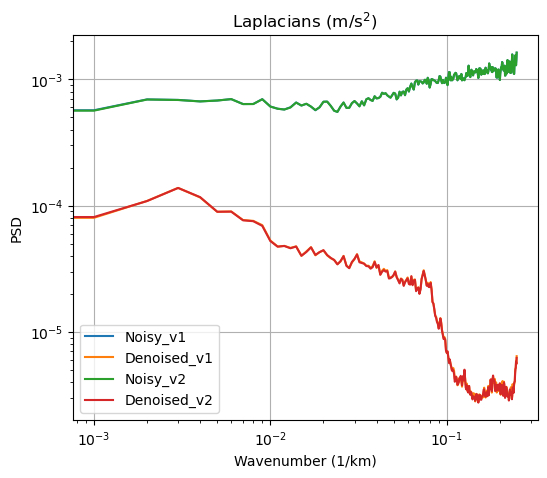

In [18]:
plt.figure(figsize=(6,5))
plt.title('Laplacians (m/s$^2$)')
plt.loglog(wavenum,psd_noisy_v1,label=label_noisy_v1)
plt.loglog(wavenum,psd_denoised_v1,label=label_denoised_v1) 
plt.loglog(wavenum,psd_noisy_v2,label=label_noisy_v2)
plt.loglog(wavenum,psd_denoised_v2,label=label_denoised_v2) 
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.grid()
plt.savefig('../figures/psd_compare_v102_'+region_info['name']+'_'+orbit+'_lapl.png')

plt.show()

